## Plot temperature and horizontal winds at chosen pressure levels

In [1]:
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import iris
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.const import init_const
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator

In [3]:
from util_commons import PLANETS, SUITES
from util_mypaths import path_to_constants, path_to_results
from util_plot_func import (
    MidpointNormalize,
    draw_scalar_cube,
    draw_vector_cubes,
    use_paper_style,
)

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
use_paper_style()

In [5]:
metallicity = "1x solar"
tgt_plevs = np.logspace(4, 6, 3)

hatp11b_const = init_const("hatp11b", directory=path_to_constants)
hd189733b_const = init_const("hd189733b", directory=path_to_constants)
hd209458b_const = init_const("hd209458b", directory=path_to_constants)
wasp17b_const = init_const("wasp17b", directory=path_to_constants)
PLANET_CONSTS = [hatp11b_const, hd189733b_const, hd209458b_const, wasp17b_const]

In [6]:
vrbls = {}
for planet in PLANETS.keys():
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        # Load data and extract the last 200 days
        fpath = SUITES[planet][exp][metallicity]["dir_for_merged"]
        fname = f"{SUITES[planet][exp][metallicity]['rose_suite']}.nc"
        air_pressure = iris.load_cube(str(fpath / fname), "air_pressure")[80:, ...]
        air_temperature = iris.load_cube(str(fpath / fname), "air_temperature")[80:, ...]
        u = iris.load_cube(str(fpath / fname), "x_wind")[80:, ...]
        v = iris.load_cube(str(fpath / fname), "y_wind")[80:, ...]
        # Regrid v wind to u wind coordinates
        v_rgrd = v.regrid(u, iris.analysis.Linear())
        # Choose target pressure level
        for tgt_plev in tqdm(tgt_plevs):
            # Interpolate to the target pressure level
            temp_plev = interp_cube_from_height_to_pressure_levels(
                air_temperature,
                air_pressure,
                tgt_plev,
                model=um,
            )
            u_plev = interp_cube_from_height_to_pressure_levels(
                u,
                air_pressure,
                tgt_plev,
                model=um,
            )
            v_plev = interp_cube_from_height_to_pressure_levels(
                v_rgrd,
                air_pressure,
                tgt_plev,
                model=um,
            )
            # Calculate 800-1000 days mean
            temp_plev_mean = temp_plev.collapsed(["time"], iris.analysis.MEAN)
            u_plev_mean = u_plev.collapsed(["time"], iris.analysis.MEAN)
            v_plev_mean = v_plev.collapsed(["time"], iris.analysis.MEAN)
            # Assemble data dictionary
            vrbls[planet][exp][tgt_plev] = {
                "temp_plev_mean": temp_plev_mean,
                "u_plev_mean": u_plev_mean,
                "v_plev_mean": v_plev_mean,
            }

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
AXGR_KW = dict(
    axes_pad=(0.3, 0.3),
    cbar_location="bottom",
    cbar_mode="single",
    cbar_pad=0.3,
    cbar_size="1.5%",
    label_mode="",
)
CART_KW = dict(transform=ccrs.PlateCarree())

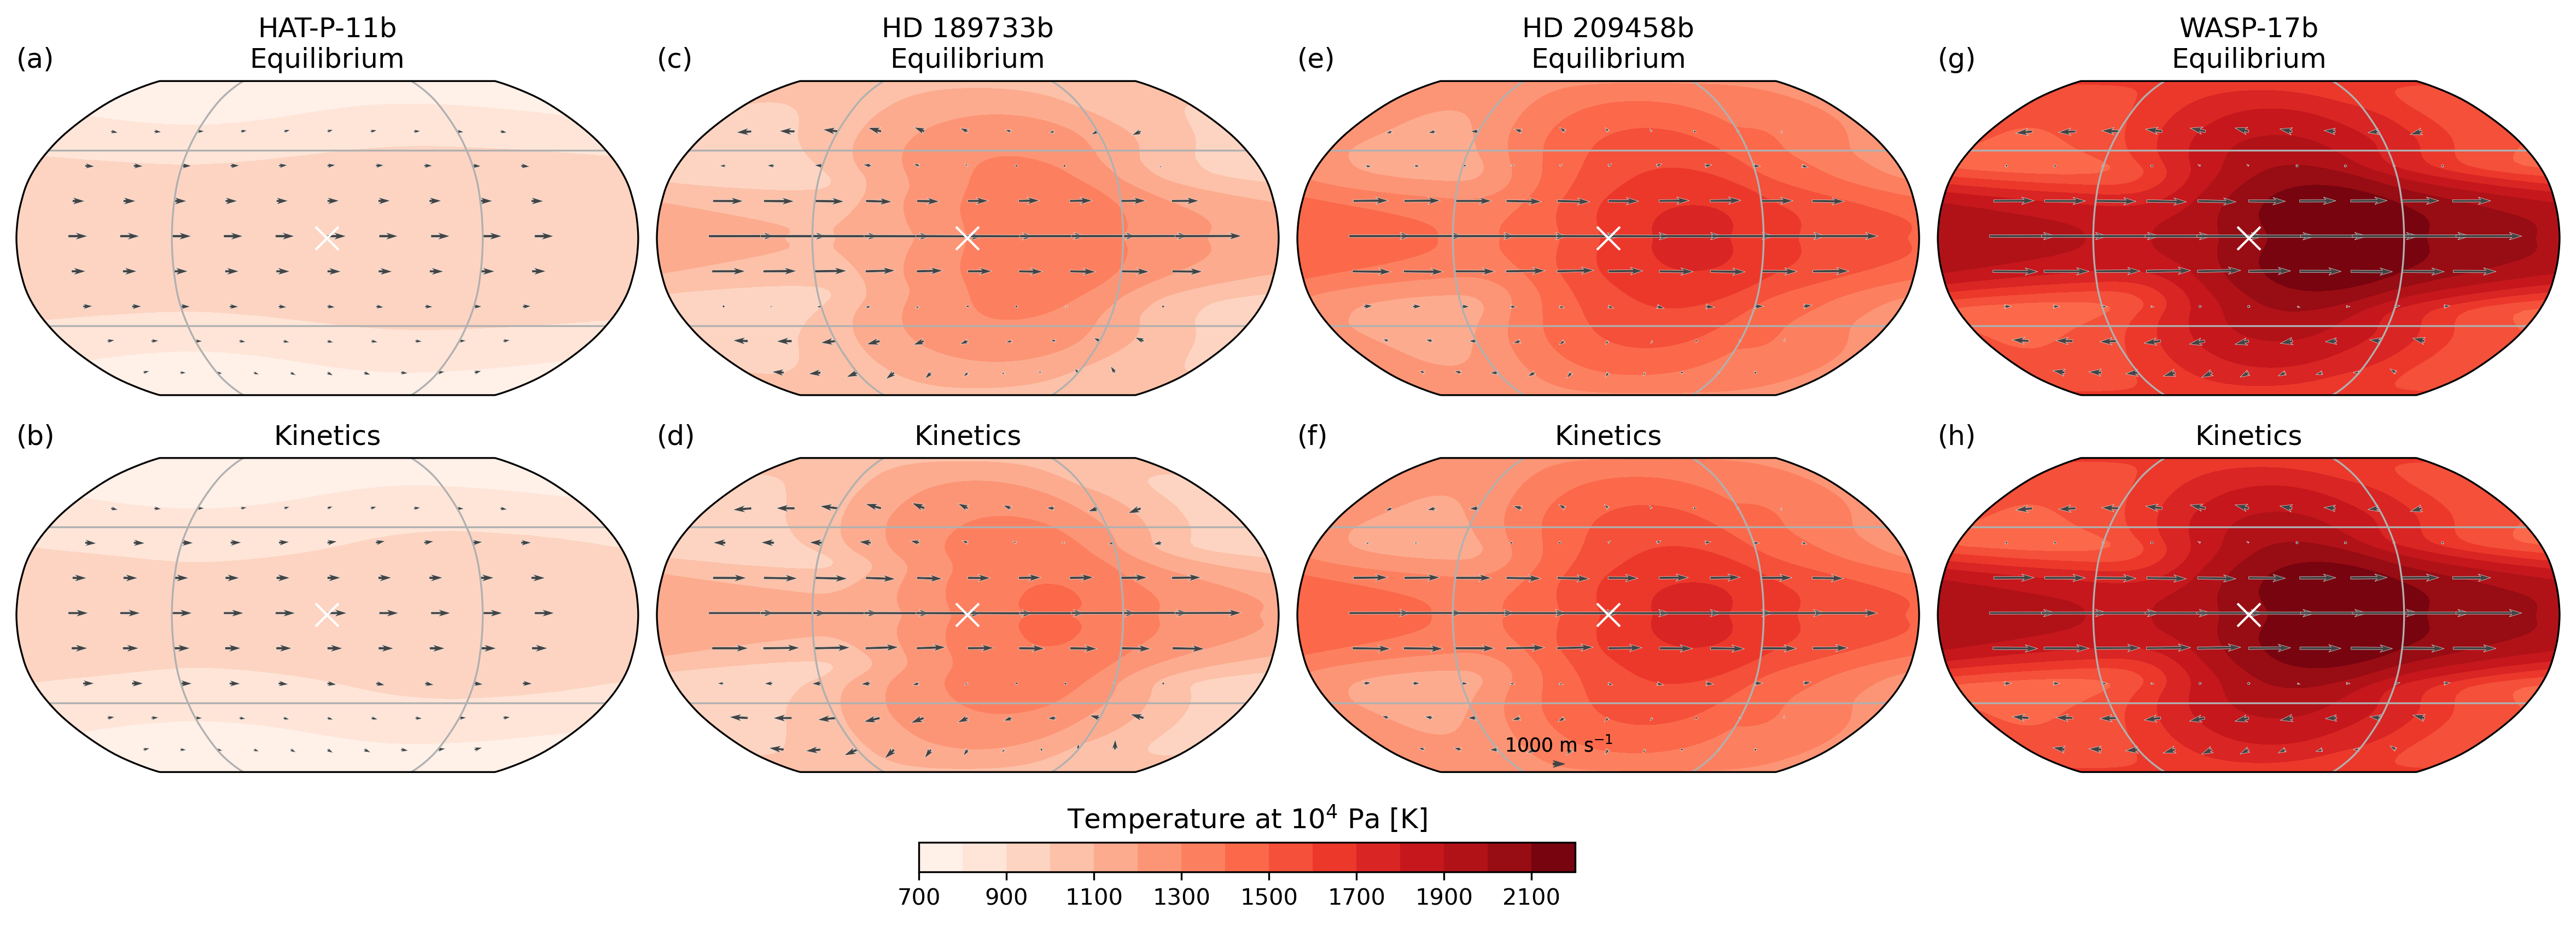

In [8]:
# Plot temperature at the target pressure level
plt_plev = tgt_plevs[0]
# Arrow specs
quiver_kw = dict(
    scale_units="inches",
    scale=14000,
    facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)
fig, axs = plt.subplots(
    2,
    4,
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)),
    figsize=(20, 6),
    gridspec_kw=dict(wspace=0.03, hspace=0.03),
)
cax = fig.add_axes([0.4, 0.05, 0.2, 0.03])
iletters = subplot_label_generator()
for j, (planet, ax_col) in enumerate(zip(PLANETS.keys(), axs.T)):
    for i, (exp, ax) in enumerate(zip(["equilibrium", "kinetics"], ax_col)):
        draw_scalar_cube(
            vrbls[planet][exp][plt_plev]["temp_plev_mean"],
            ax,
            method="contourf",
            cax=cax,
            cbar_ttl="Temperature at $10^4$ Pa [K]",
            cmap="Reds",
            levels=np.arange(
                700, 2300, 100
            ),  # individual (700, 2300, 100), common (700, 2600, 100)
        )
        draw_vector_cubes(
            vrbls[planet][exp][plt_plev]["u_plev_mean"],
            vrbls[planet][exp][plt_plev]["v_plev_mean"],
            ax,
            xstride=4 * 3,
            ystride=3 * 3,
            qk_ref_wspd=1000,
            **quiver_kw,
            **CART_KW,
        )
        ax.plot(0, 0, markersize=10, marker="x", color="w")
        ax.set_title(f"({next(iletters)})", loc="left")
        if ax.get_subplotspec().is_first_row():
            ax.set_title(f"{PLANETS[planet]['tex']}\n{exp.capitalize()}", loc="center")
        if ax.get_subplotspec().is_last_row():
            ax.set_title(f"{exp.capitalize()}", loc="center")
        gl = ax.gridlines(draw_labels=False, xlocs=[-90, 90], ylocs=[-45, 45])
fig.savefig(
    path_to_results / "circulation" / f"temp_hwind_plev_1e4_robinson.png",
)

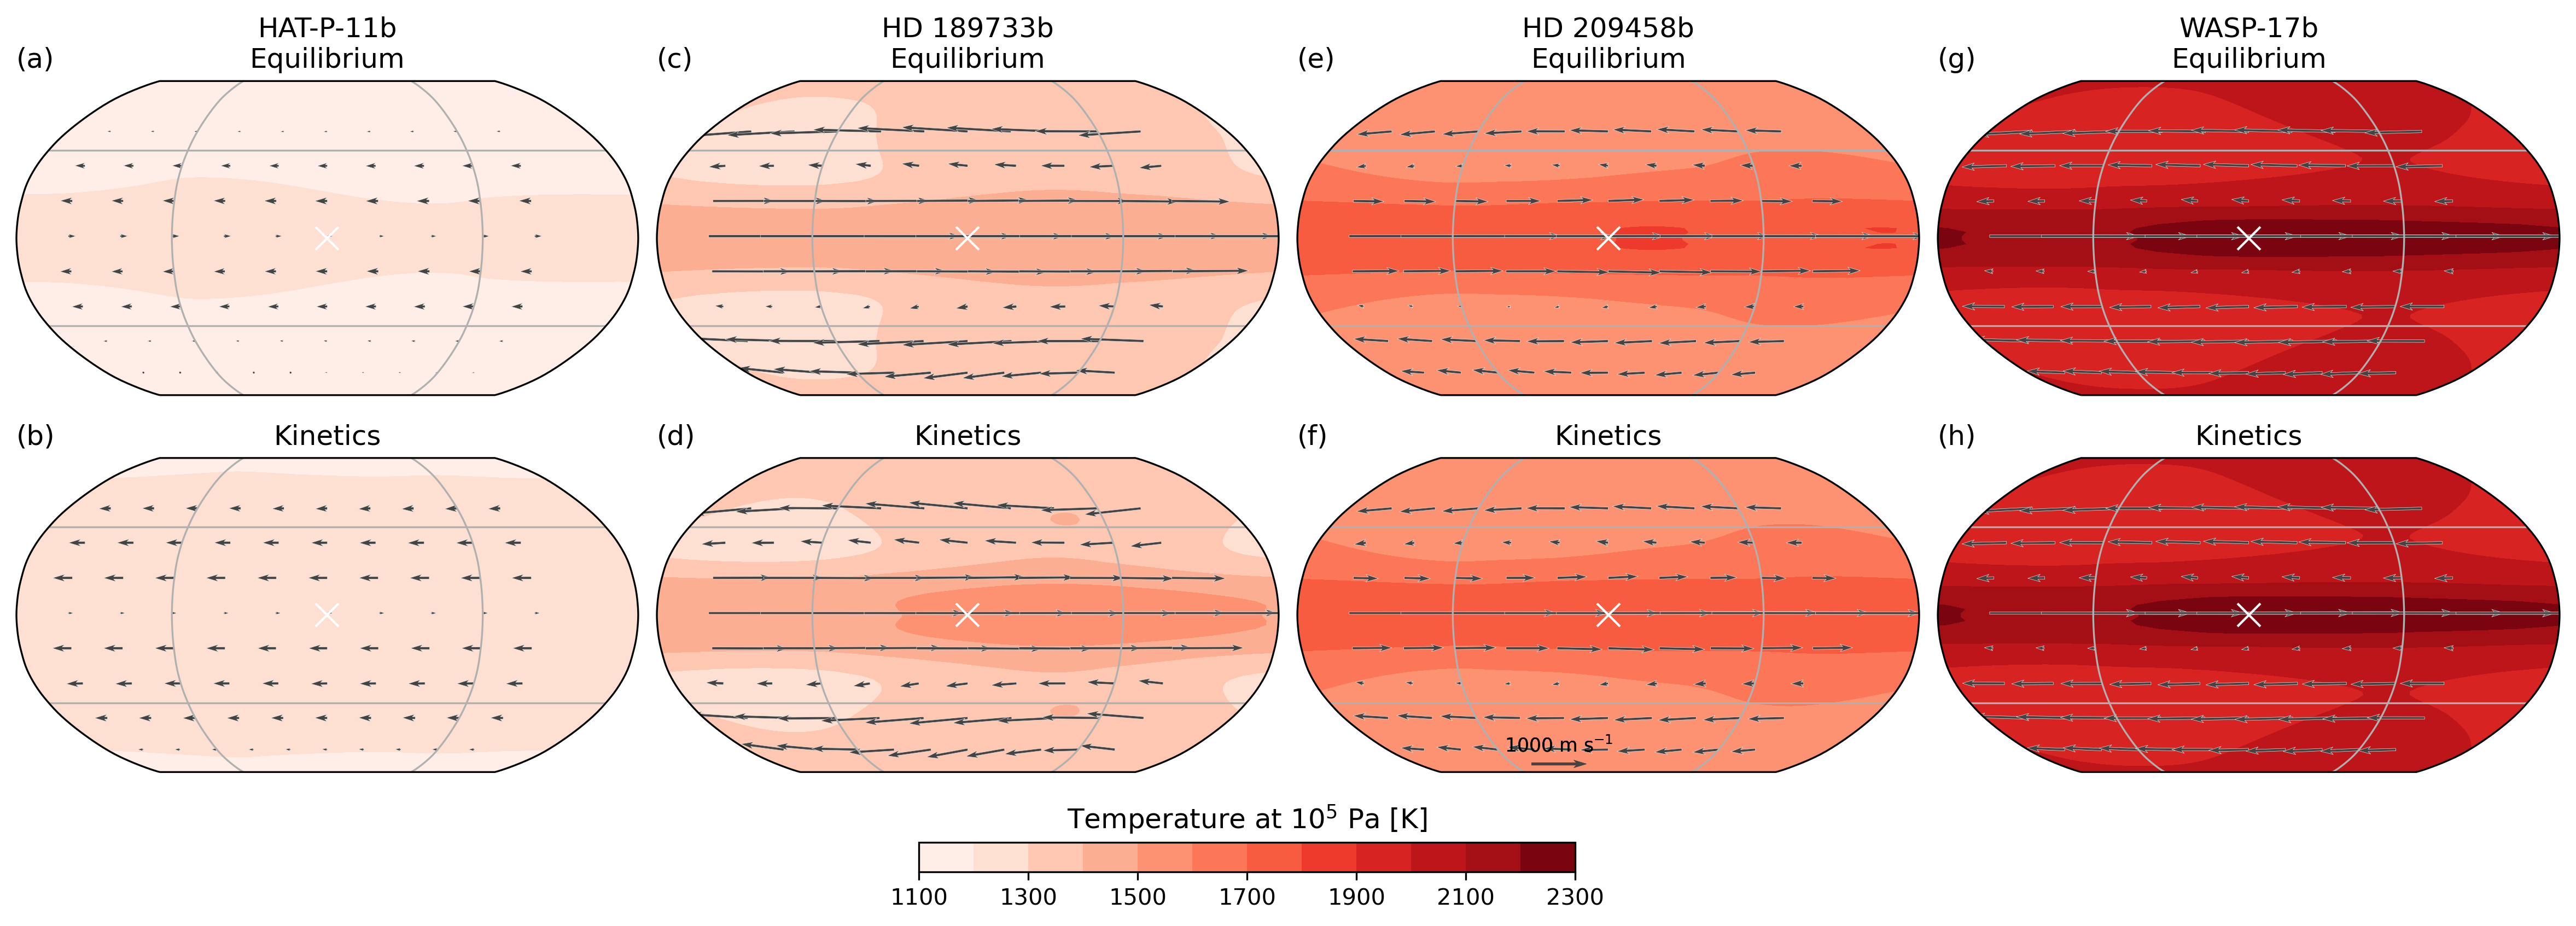

In [9]:
# Plot temperature at the target pressure level
plt_plev = tgt_plevs[1]
# Arrow specs
quiver_kw = dict(
    scale_units="inches",
    scale=3000,
    facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)
fig, axs = plt.subplots(
    2,
    4,
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)),
    figsize=(20, 6),
    gridspec_kw=dict(wspace=0.03, hspace=0.03),
)
cax = fig.add_axes([0.4, 0.05, 0.2, 0.03])
iletters = subplot_label_generator()
for j, (planet, ax_col) in enumerate(zip(PLANETS.keys(), axs.T)):
    for i, (exp, ax) in enumerate(zip(["equilibrium", "kinetics"], ax_col)):
        draw_scalar_cube(
            vrbls[planet][exp][plt_plev]["temp_plev_mean"],
            ax,
            method="contourf",
            cax=cax,
            cbar_ttl="Temperature at $10^5$ Pa [K]",
            cmap="Reds",
            levels=np.arange(
                1100, 2400, 100
            ),  # individual (1100, 2400, 100), common (700, 2600, 100)
        )
        draw_vector_cubes(
            vrbls[planet][exp][plt_plev]["u_plev_mean"],
            vrbls[planet][exp][plt_plev]["v_plev_mean"],
            ax,
            xstride=4 * 3,
            ystride=3 * 3,
            qk_ref_wspd=1000,
            **quiver_kw,
            **CART_KW,
        )
        ax.plot(0, 0, markersize=10, marker="x", color="w")
        ax.set_title(f"({next(iletters)})", loc="left")
        if ax.get_subplotspec().is_first_row():
            ax.set_title(f"{PLANETS[planet]['tex']}\n{exp.capitalize()}", loc="center")
        if ax.get_subplotspec().is_last_row():
            ax.set_title(f"{exp.capitalize()}", loc="center")
        gl = ax.gridlines(draw_labels=False, xlocs=[-90, 90], ylocs=[-45, 45])
fig.savefig(
    path_to_results / "circulation" / f"temp_hwind_plev_1e5_robinson.png",
)